In [1]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import spatial
import tqdm

from pymutspec.annotation import mutations_summary, calculate_mutspec, lbl_id2lbl, lbl2lbl_id
from pymutspec.constants import possible_sbs192, possible_sbs12
from pymutspec.draw import plot_mutspec192, plot_mutspec12
from pymutspec.draw.sbs_orders import ordered_sbs192_kp

## Load data

In [2]:
PATH_TO_DATA = "../data/exposure/mammals_nd1/"

### Load observed mutations

In [3]:
path_to_mutations_simple = os.path.join(PATH_TO_DATA, "simple/mutations.tsv")
path_to_mutations_proba = os.path.join(PATH_TO_DATA, "proba/mutations.tsv")
path_to_mutations_pastml = os.path.join(PATH_TO_DATA, "pastml/mutations.tsv")

mut_simple = pd.read_csv(path_to_mutations_simple, sep='\t').assign(Aproach="simple")
mut_iqtree = pd.read_csv(path_to_mutations_proba, sep='\t').assign(Aproach="iqtree")
mut_pastml = pd.read_csv(path_to_mutations_pastml, sep='\t').assign(Aproach="pastml")

mut_nd1 = pd.concat([mut_simple, mut_iqtree, mut_pastml], ignore_index=True).fillna(1)
mut_nd1["MutBase"] = mut_nd1["Mut"].str.slice(2, 5)

### Load expected mutations freqs

In [4]:
path_to_freqs_simple = os.path.join(PATH_TO_DATA, "simple/expected_mutations.tsv")
path_to_freqs_iqtree = os.path.join(PATH_TO_DATA, "proba/expected_mutations.tsv")
path_to_freqs_pastml = os.path.join(PATH_TO_DATA, "pastml/expected_mutations.tsv")

freqs_simple = pd.read_csv(path_to_freqs_simple, sep='\t').drop_duplicates().assign(Aproach="simple")
freqs_iqtree = pd.read_csv(path_to_freqs_iqtree, sep='\t').drop_duplicates().assign(Aproach="iqtree")
freqs_pastml = pd.read_csv(path_to_freqs_pastml, sep='\t').drop_duplicates().assign(Aproach="pastml")

freqs_nd1 = pd.concat([freqs_simple, freqs_iqtree, freqs_pastml], ignore_index=True)

freqs_simple.shape, freqs_iqtree.shape, freqs_pastml.shape, freqs_nd1.shape

((3966, 208), (3966, 208), (3969, 208), (11901, 208))

In [5]:
freqs_nd1.head()

,Node,Gene,Label,A>C,A>G,A>T,C>A,C>G,C>T,G>A,...,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T,Aproach
0,Node1242,1,all,328.0,328.0,328.0,278.0,278.0,278.0,113.0,...,3.0,15.0,4.0,1.0,3.0,12.0,15.0,4.0,8.0,simple
1,Node1242,1,syn,134.0,188.0,134.0,43.0,43.0,145.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,simple
2,Node1242,1,ff,134.0,134.0,134.0,43.0,43.0,43.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,simple
3,Node1243,1,all,321.0,321.0,321.0,287.0,287.0,287.0,113.0,...,6.0,13.0,5.0,1.0,3.0,13.0,15.0,4.0,8.0,simple
4,Node1243,1,syn,127.0,181.0,127.0,51.0,51.0,152.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,simple


### Load edges mutational spectra

In [6]:
mutspec_simple12 = pd.read_csv(os.path.join(PATH_TO_DATA, "simple/mutspec12.tsv"), sep='\t').assign(Aproach="simple")
mutspec_iqtree12 = pd.read_csv(os.path.join(PATH_TO_DATA, "proba/mutspec12.tsv"), sep='\t').assign(Aproach="iqtree")
mutspec_pastml12 = pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/mutspec12.tsv"), sep='\t').assign(Aproach="pastml")
spectra12_nd1 = pd.concat([mutspec_simple12, mutspec_iqtree12, mutspec_pastml12], ignore_index=True)

mutspec_simple192 = pd.read_csv(os.path.join(PATH_TO_DATA, "simple/mutspec192.tsv"), sep='\t').assign(Aproach="simple")
mutspec_iqtree192 = pd.read_csv(os.path.join(PATH_TO_DATA, "proba/mutspec192.tsv"), sep='\t').assign(Aproach="iqtree")
mutspec_pastml192 = pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/mutspec192.tsv"), sep='\t').assign(Aproach="pastml")
spectra192_nd1 = pd.concat([mutspec_simple192, mutspec_iqtree192, mutspec_pastml192], ignore_index=True)

## Brief analysis of observed mutations

In [7]:
print(mut_simple.shape)
mut_simple.head()

(75946, 12)


,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,RefNode,AltNode,Gene,MutBase
0,G[T>C]A,2,102,3,CGT,CGC,R,R,Node1242,Node1243,1,T>C
1,C[A>C]A,2,375,3,TCA,TCC,S,S,Node1242,Node1243,1,A>C
2,A[T>C]G,1,426,3,TAT,TAC,Y,Y,Node1242,Node1243,1,T>C
3,T[A>C]T,2,624,3,GTA,GTC,V,V,Node1242,Node1243,1,A>C
4,C[A>T]G,2,627,3,TCA,TCT,S,S,Node1242,Node1243,1,A>T


In [8]:
print(mut_iqtree.shape)
mut_iqtree.head()

(1186310, 15)


,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,ProbaFull,RefNode,AltNode,Gene,MutBase
0,T[C>T]A,1,6,3,TTC,TTT,F,F,0.251434,0.170464,0.154744,Node1242,Node1243,1,C>T
1,T[T>C]A,1,6,3,TTT,TTC,F,F,0.676315,0.173435,0.157441,Node1242,Node1243,1,T>C
2,T[C>T]G,1,6,3,TTC,TTT,F,F,0.019502,0.000925,0.000839,Node1242,Node1243,1,C>T
3,T[T>C]G,1,6,3,TTT,TTC,F,F,0.052458,0.000941,0.000854,Node1242,Node1243,1,T>C
4,C[A>G]T,0,7,1,ATA,GTA,M,V,0.224317,0.003597,0.003265,Node1242,Node1243,1,A>G


In [10]:
print(mut_pastml.shape)
mut_pastml.head()

(1330609, 15)


,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,ProbaFull,RefNode,AltNode,Gene,MutBase
0,G[C>T]C,0,4,1,CCC,TCC,P,S,0.018706,0.018706,0.018706,ROOT,OUTGRP,1,C>T
1,T[A>C]C,0,5,2,TAC,TCC,Y,S,0.031802,0.031802,0.031802,ROOT,OUTGRP,1,A>C
2,T[T>C]C,0,5,2,TTC,TCC,F,S,0.238171,0.238171,0.238171,ROOT,OUTGRP,1,T>C
3,C[T>C]G,2,6,3,TCT,TCC,S,S,0.020677,0.020677,0.020677,ROOT,OUTGRP,1,T>C
4,C[A>G]C,0,7,1,ACA,GCA,T,A,0.112595,0.112595,0.112595,ROOT,OUTGRP,1,A>G


### How many mutations with diffrent types observed?

In [201]:
mutations_summary(mut_nd1, "Aproach", "ProbaFull").round(2)

,non-syn,syn,syn4f,Stop loss,Stop gain,Stop to stop
Aproach,,,,,,
iqtree,8143.34,107114.12,59834.81,8.91,4.54,0.06
pastml,9005.71,118552.30,58877.74,10.69,5.44,0.03
simple,8358.00,67575.00,35267.00,9.00,4.00,0.00


In [202]:
mutations_summary(mut_nd1[mut_nd1.ProbaFull > 0.3], "Aproach", "ProbaFull").round(2)

,non-syn,syn,syn4f,Stop loss,Stop gain
Aproach,,,,,
iqtree,4862.25,49671.83,25296.68,1.81,1.72
pastml,5088.36,53128.32,26792.37,1.94,1.61
simple,8358.00,67575.00,35267.00,9.00,4.00


**Probability distribution of mutations**

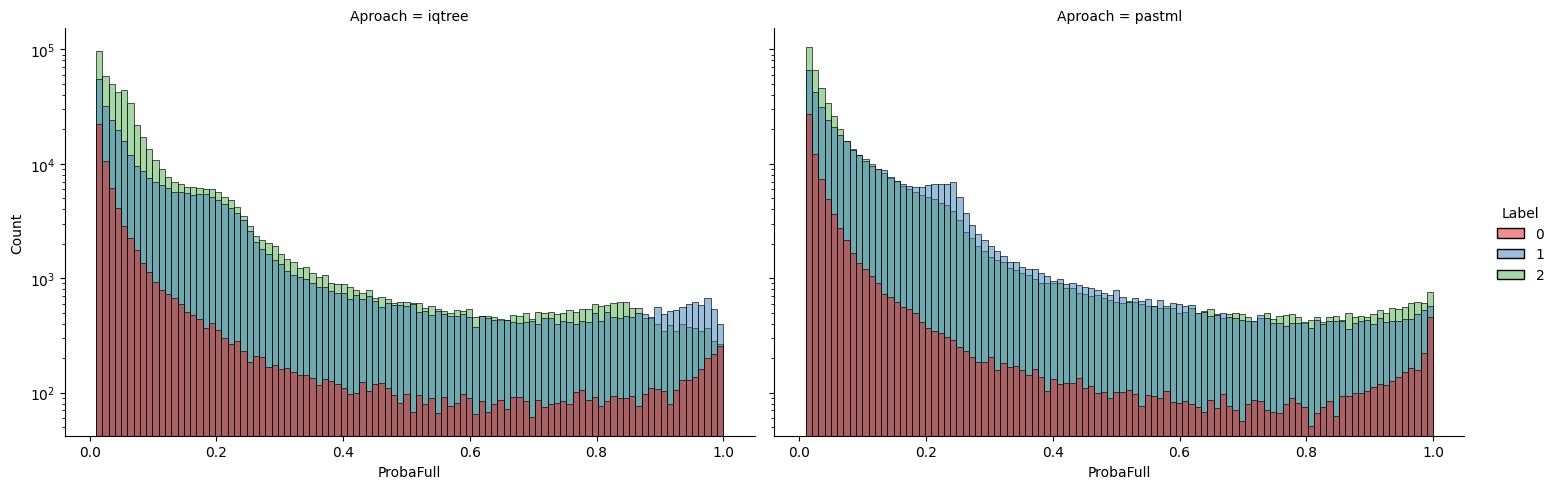

In [217]:
sns.displot(
    data=mut_nd1[(mut_nd1.Label >= 0) & (mut_nd1.Aproach != "simple") & (mut_nd1.ProbaFull > 0.01)], 
    x="ProbaFull", hue="Label", col="Aproach", 
    log_scale=[False, True], bins=100, palette="Set1", aspect=1.5,
);

**Number of mutations in tree edges**

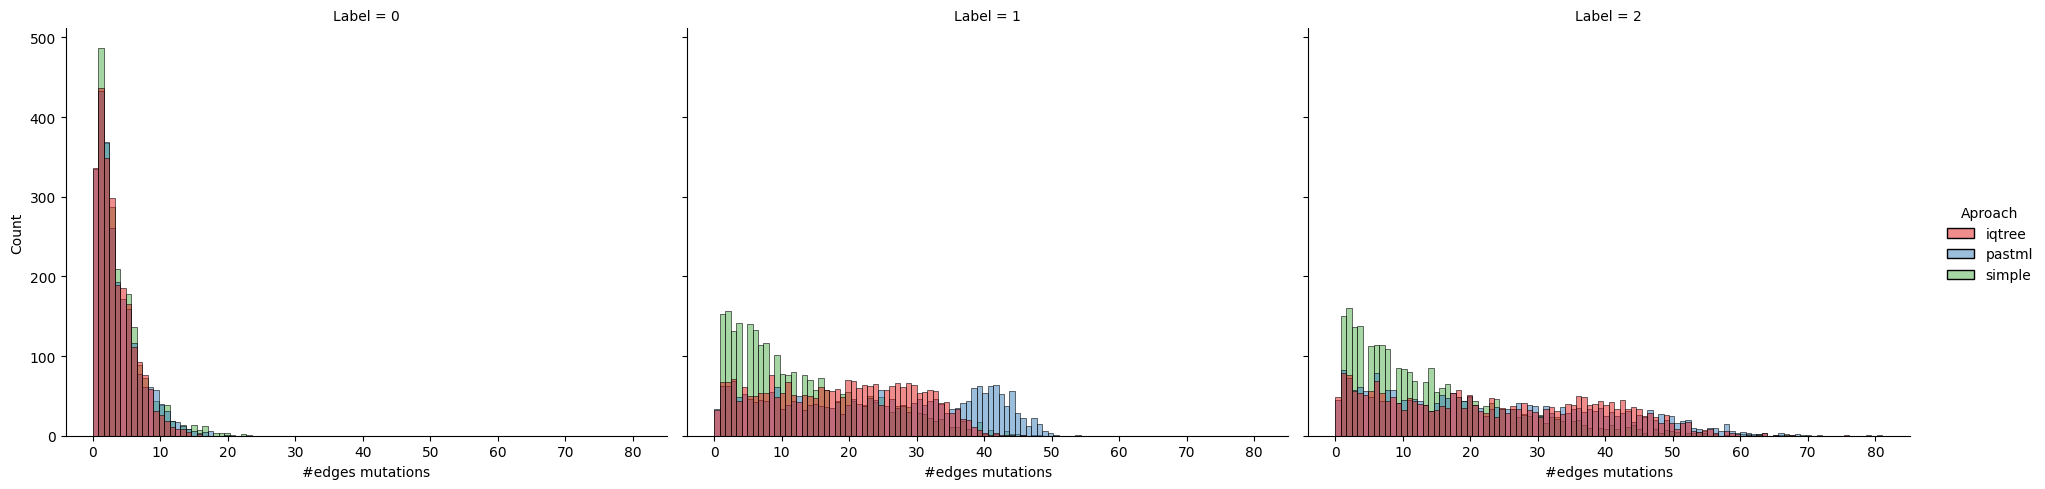

In [232]:
sns.displot(
    data=mut_nd1[mut_nd1.Label >= 0].groupby(["Aproach", "Label", "AltNode"]).ProbaFull.sum().reset_index(), 
    x="ProbaFull", col="Label", hue="Aproach", aspect=1.3, palette="Set1", bins=100,
).set_axis_labels("#edges mutations");

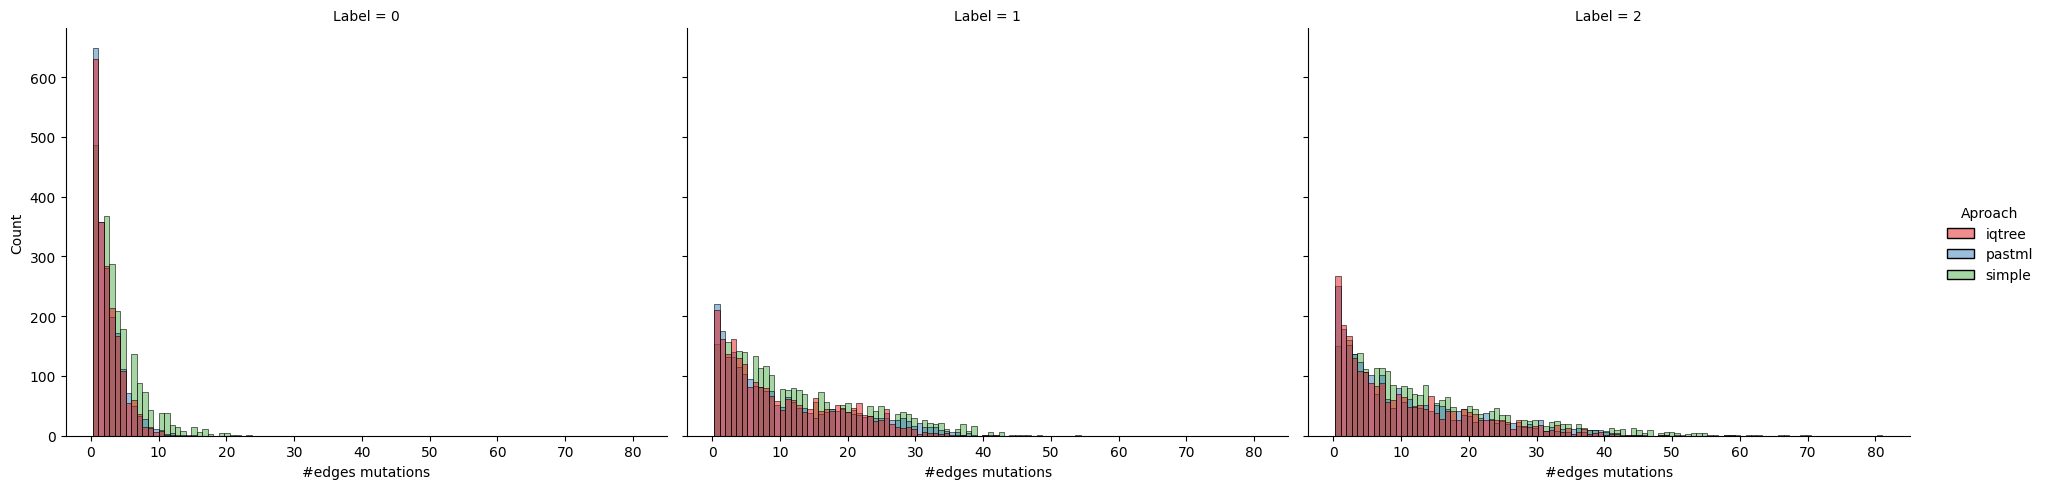

In [233]:
# after filtration (P > 0.3)
sns.displot(
    data=mut_nd1[(mut_nd1.Label >= 0) & (mut_nd1.ProbaFull > 0.3)].groupby(["Aproach", "Label", "AltNode"]).ProbaFull.sum().reset_index(), 
    x="ProbaFull", col="Label", hue="Aproach", aspect=1.3, palette="Set1", facet_kws=dict(sharex=False), bins=100,
).set_axis_labels("#edges mutations");

## Mutspec

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


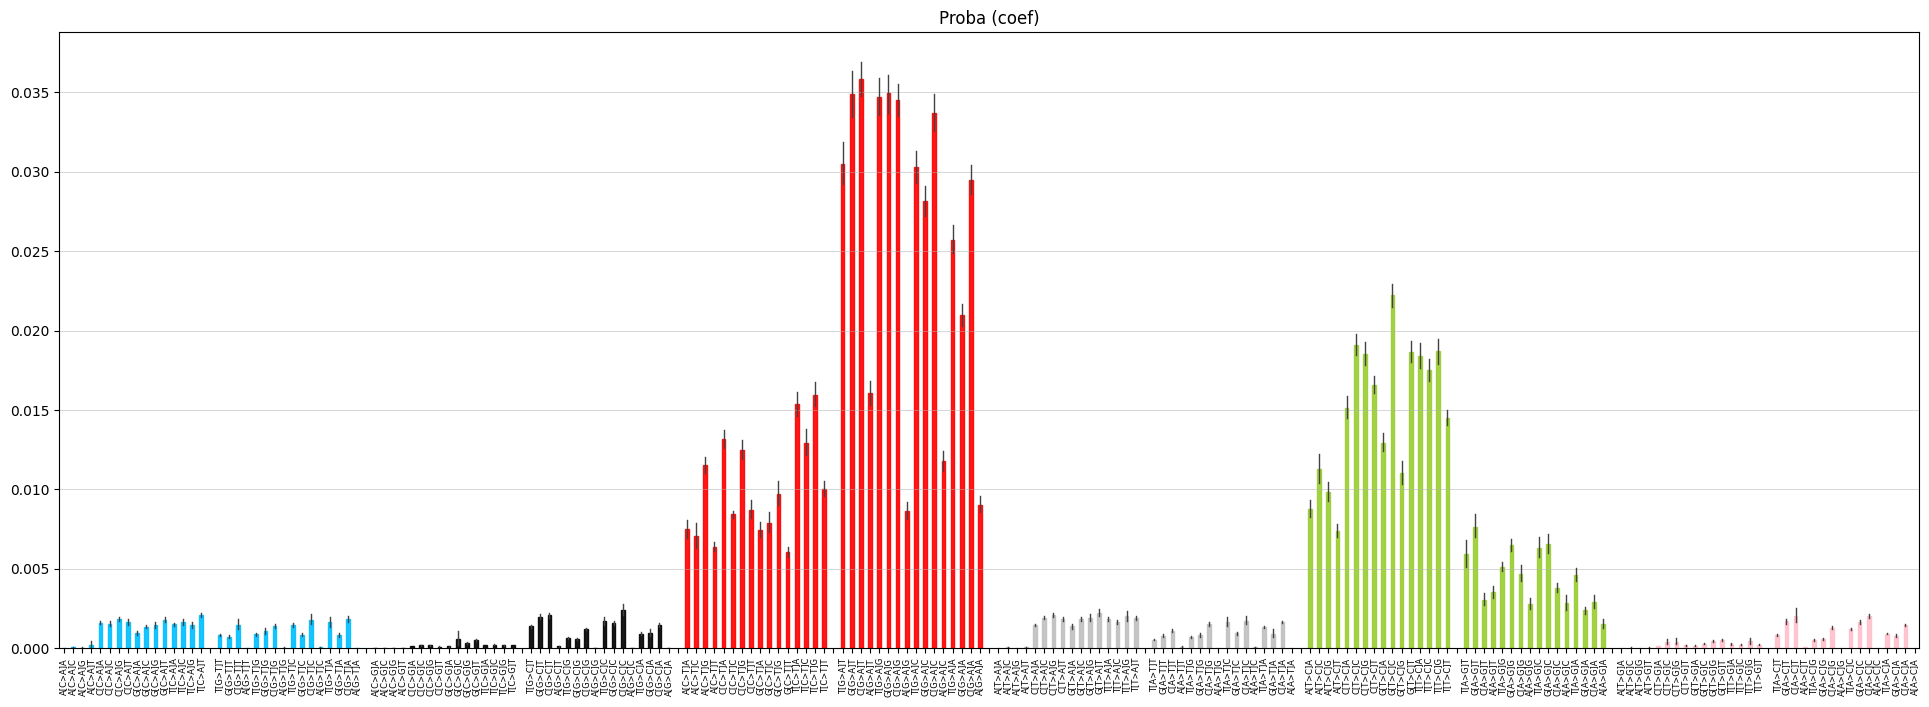

In [15]:
plot_mutspec192(mutspec_iqtree192, title="Proba (coef)")

### Edges Cossim

In [7]:
# 12
# choose edges with more than or equal to 10 observed mutations to compare 12-comp spectra
nmut_threshhold12 = 10

edges_muts_simple12 = mutspec_simple12[mutspec_simple12.Label == "syn"].groupby("AltNode").ObsNum.sum().sort_values()
edges_muts_iqtree12 = mutspec_iqtree12[mutspec_iqtree12.Label == "syn"].groupby("AltNode").ObsNum.sum().sort_values()
edges_muts_pastml12 = mutspec_pastml12[mutspec_pastml12.Label == "syn"].groupby("AltNode").ObsNum.sum().sort_values()

altnodes_simple12 = list(edges_muts_simple12[edges_muts_simple12 >= nmut_threshhold12].index.values)
altnodes_iqtree12 = list(edges_muts_iqtree12[edges_muts_iqtree12 >= nmut_threshhold12].index.values)
altnodes_pastml12 = list(edges_muts_pastml12[edges_muts_pastml12 >= nmut_threshhold12].index.values)

altnodes_full12 = set(altnodes_simple12).intersection(altnodes_iqtree12).intersection(altnodes_pastml12)
print("#edges =", len(altnodes_full12))

mutspec_simple12_wide = mutspec_simple12[mutspec_simple12.AltNode.isin(altnodes_full12)].pivot(["RefNode", "AltNode", "Label"], "Mut", "MutSpec")
mutspec_iqtree12_wide = mutspec_iqtree12[mutspec_iqtree12.AltNode.isin(altnodes_full12)].pivot(["RefNode", "AltNode", "Label"], "Mut", "MutSpec")
mutspec_pastml12_wide = mutspec_pastml12[mutspec_pastml12.AltNode.isin(altnodes_full12)].pivot(["RefNode", "AltNode", "Label"], "Mut", "MutSpec")

# check that we can compare tables directly
assert np.all(mutspec_simple12_wide.index == mutspec_iqtree12_wide.index)
assert np.all(mutspec_pastml12_wide.index == mutspec_iqtree12_wide.index)
assert np.all(mutspec_simple12_wide.columns == mutspec_iqtree12_wide.columns)
assert np.all(mutspec_pastml12_wide.columns == mutspec_iqtree12_wide.columns)

#edges = 1878


In [8]:
# 192
# choose edges with more than or equal to 50 observed mutations to compare 192-comp spectra
nmut_threshhold192 = 50

edges_muts_simple192 = mutspec_simple192[mutspec_simple192.Label == "syn"].groupby("AltNode").ObsNum.sum().sort_values()
edges_muts_iqtree192 = mutspec_iqtree192[mutspec_iqtree192.Label == "syn"].groupby("AltNode").ObsNum.sum().sort_values()
edges_muts_pastml192 = mutspec_pastml192[mutspec_pastml192.Label == "syn"].groupby("AltNode").ObsNum.sum().sort_values()

altnodes_simple192 = list(edges_muts_simple192[edges_muts_simple192 >= nmut_threshhold192].index.values)
altnodes_iqtree192 = list(edges_muts_iqtree192[edges_muts_iqtree192 >= nmut_threshhold192].index.values)
altnodes_pastml192 = list(edges_muts_pastml192[edges_muts_pastml192 >= nmut_threshhold192].index.values)

altnodes_full192 = set(altnodes_simple192).intersection(altnodes_iqtree192).intersection(altnodes_pastml192)
print("#edges =", len(altnodes_full192))

mutspec_simple192_wide = mutspec_simple192[mutspec_simple192.AltNode.isin(altnodes_full192)].pivot(["RefNode", "AltNode", "Label"], "Mut", "MutSpec")
mutspec_iqtree192_wide = mutspec_iqtree192[mutspec_iqtree192.AltNode.isin(altnodes_full192)].pivot(["RefNode", "AltNode", "Label"], "Mut", "MutSpec")
mutspec_pastml192_wide = mutspec_pastml192[mutspec_pastml192.AltNode.isin(altnodes_full192)].pivot(["RefNode", "AltNode", "Label"], "Mut", "MutSpec")

# check that we can compare tables directly
assert np.all(mutspec_simple192_wide.index == mutspec_iqtree192_wide.index)
assert np.all(mutspec_pastml192_wide.index == mutspec_iqtree192_wide.index)
assert np.all(mutspec_simple192_wide.columns == mutspec_iqtree192_wide.columns)
assert np.all(mutspec_pastml192_wide.columns == mutspec_iqtree192_wide.columns)

#edges = 408


In [9]:
def get_cossim(a: pd.DataFrame, b: pd.DataFrame):
    dotprod = (a * b).sum(axis=1)
    a_norm = (a ** 2).sum(axis=1) ** 0.5
    b_norm = (b ** 2).sum(axis=1) ** 0.5
    cossim = dotprod / (a_norm * b_norm)
    return cossim

get_cossim(mutspec_simple12_wide, mutspec_iqtree12_wide)

RefNode  AltNode  Label
Node1    RN_1089  all      0.836256
                  ff       0.471938
                  syn      0.556626
         RN_1093  all      0.855397
                  ff       0.655680
                             ...   
Node997  RN_1128  ff       0.979096
                  syn      0.999571
         RN_1129  all      0.996119
                  ff       0.894431
                  syn      0.988521
Length: 5634, dtype: float64

In [171]:
# 12
cossim12_total = pd.concat([
    get_cossim(mutspec_simple12_wide, mutspec_iqtree12_wide).rename("Cossim").reset_index().assign(Pair="simple_vs_iqtree"), 
    get_cossim(mutspec_simple12_wide, mutspec_pastml12_wide).rename("Cossim").reset_index().assign(Pair="simple_vs_pastml"), 
    get_cossim(mutspec_iqtree12_wide, mutspec_pastml12_wide).rename("Cossim").reset_index().assign(Pair="iqtree_vs_pastml"),
], ignore_index=True)

# 192
cossim192_total = pd.concat([
    get_cossim(mutspec_simple192_wide, mutspec_iqtree192_wide).rename("Cossim").reset_index().assign(Pair="simple_vs_iqtree"), 
    get_cossim(mutspec_simple192_wide, mutspec_pastml192_wide).rename("Cossim").reset_index().assign(Pair="simple_vs_pastml"), 
    get_cossim(mutspec_iqtree192_wide, mutspec_pastml192_wide).rename("Cossim").reset_index().assign(Pair="iqtree_vs_pastml"),
], ignore_index=True)

In [173]:
# concat 12 and 192
cossim12_total["ncomp"] = 12
cossim192_total["ncomp"] = 192
cossim_total = pd.concat([cossim12_total, cossim192_total], ignore_index=True)
cossim_total["Label"] = cossim_total["Label"].replace({"ff":"syn4f"})

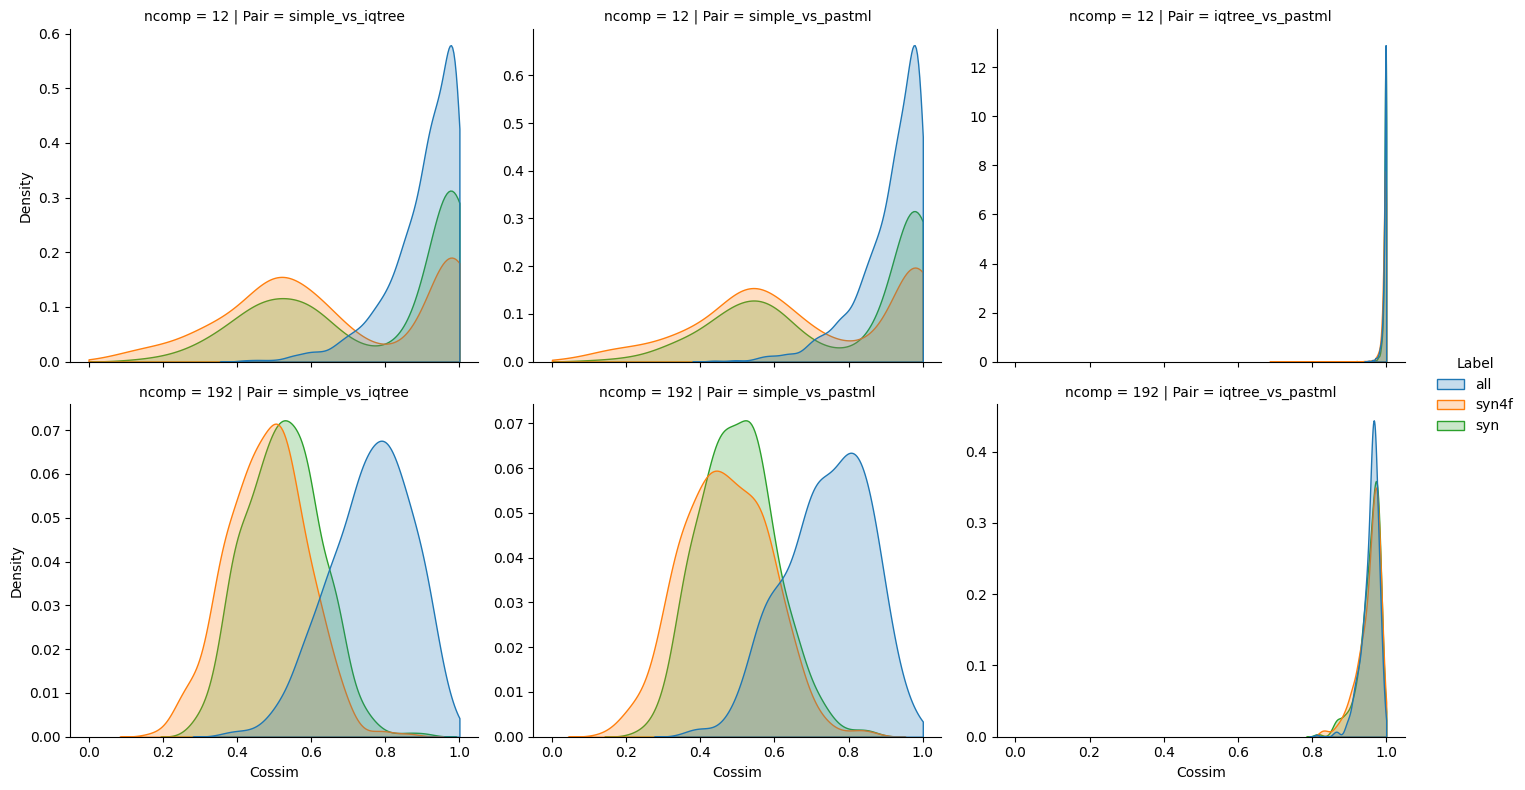

In [175]:
sns.displot(
    data=cossim_total,
    x="Cossim", hue="Label", col="Pair", row="ncomp", 
    kind="kde", fill=True, clip=(0, 1), height=4, aspect=1.2,
    facet_kws=dict(sharex=True, sharey=False), 
);

#### Legacy (for loop)

In [37]:
# first try
sims_data12 = []
for lbl in mutspec_simple12.Label.unique():
    df_lbl = 
    for anode in tqdm.tqdm(set(mutspec_simple12.AltNode), lbl):
        df1 = mutspec_simple12[(mutspec_simple12.Label == lbl) & (mutspec_simple12.AltNode == anode)].set_index("Mut").sort_index()
        df2 = mutspec_iqtree12[(mutspec_iqtree12.Label == lbl) & (mutspec_iqtree12.AltNode == anode)].set_index("Mut").sort_index()
        df3 = mutspec_pastml12[(mutspec_pastml12.Label == lbl) & (mutspec_pastml12.AltNode == anode)].set_index("Mut").sort_index()

        if len(df1) < 10 or len(df2) < 10 or len(df3) < 10:
            continue

        sim12 = 1 - spatial.distance.cosine(df1["MutSpec"], df2["MutSpec"])
        sim13 = 1 - spatial.distance.cosine(df1["MutSpec"], df3["MutSpec"])
        sim23 = 1 - spatial.distance.cosine(df2["MutSpec"], df3["MutSpec"])
        
        sims_data12.append({
            "Label": "syn4f" if lbl == "ff" else lbl, 
            "AltNode": anode, 
            "cossim simple&iqtree": sim12, "cossim simple&pastml": sim13, "cossim iqtree&pastml": sim23,
        })
sims_df12 = pd.DataFrame(sims_data12).sort_values("Label")

ff: 100%|██████████| 2557/2557 [02:03<00:00, 20.69it/s]


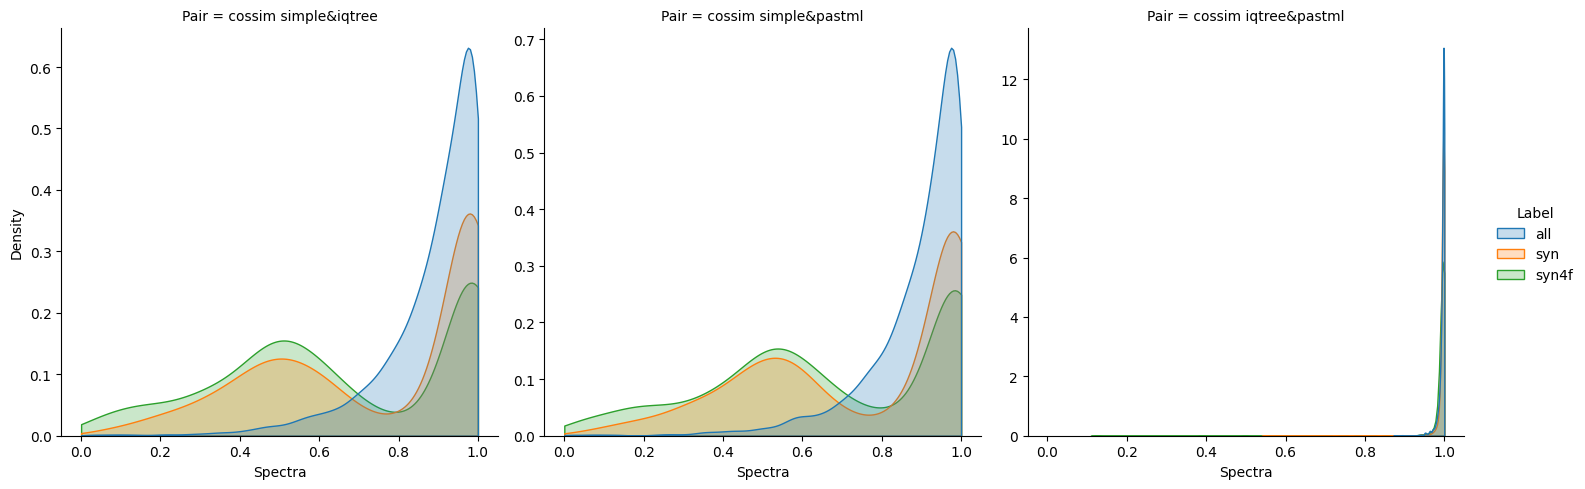

In [39]:
sns.displot(
    data=sims_df12.melt("Label", sims_df12.columns[-3:], "Pair", "Spectra"), 
    x="Spectra", col="Pair", hue="Label", 
    kind="kde", fill=True, clip=(0, 1),
    facet_kws=dict(sharex=True, sharey=False),
);

In [50]:
sims_data192 = []
for lbl in mutspec_simple192.Label.unique():
    df_simple = mutspec_simple192[(mutspec_simple192.Label == lbl)]
    df_iqtree = mutspec_iqtree192[(mutspec_iqtree192.Label == lbl)]
    df_pastml = mutspec_pastml192[(mutspec_pastml192.Label == lbl)]
                            
    for anode in tqdm.tqdm(set(mutspec_simple192.AltNode), lbl):
        nmut = 50

        df1 = df_simple[(df_simple.AltNode == anode)].set_index("Mut").sort_index()
        if (df1.MutSpec > 0).sum() < nmut:
            continue
        df2 = df_iqtree[(df_iqtree.AltNode == anode)].set_index("Mut").sort_index()
        if (df2.MutSpec > 0).sum() < nmut:
            continue
        df3 = df_pastml[(df_pastml.AltNode == anode)].set_index("Mut").sort_index()
        if (df3.MutSpec > 0).sum() < nmut:
            continue

        sim12 = 1 - spatial.distance.cosine(df1["MutSpec"], df2["MutSpec"])
        sim13 = 1 - spatial.distance.cosine(df1["MutSpec"], df3["MutSpec"])
        sim23 = 1 - spatial.distance.cosine(df2["MutSpec"], df3["MutSpec"])
        
        sims_data192.append({
            "Label": "syn4f" if lbl == "ff" else lbl, 
            "AltNode": anode, 
            "cossim simple&iqtree": sim12, "cossim simple&pastml": sim13, "cossim iqtree&pastml": sim23,
        })
sims_df192 = pd.DataFrame(sims_data192).sort_values("Label")
sims_df192.to_csv("../data/sims_df192_nd1.csv", index=False)

ff: 100%|██████████| 2557/2557 [01:46<00:00, 23.96it/s]


all    51
syn     7
Name: Label, dtype: int64


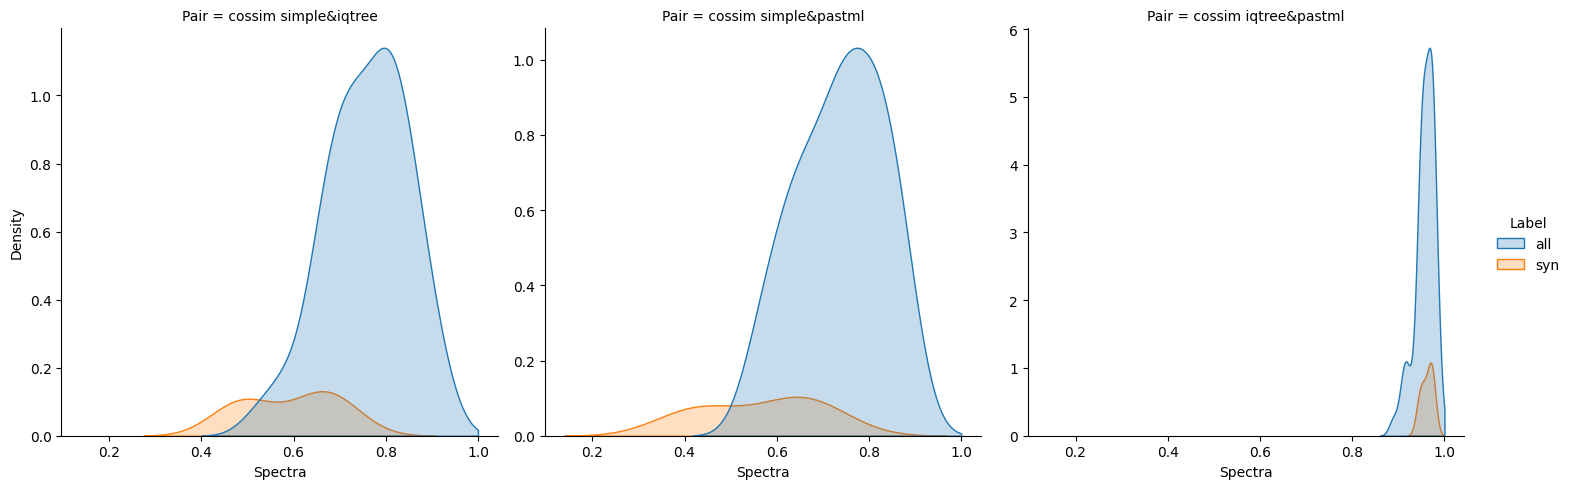

In [51]:
print(sims_df192.Label.value_counts())
sns.displot(
    data=sims_df192.melt("Label", sims_df192.columns[-3:], "Pair", "Spectra"), 
    x="Spectra", col="Pair", hue="Label", 
    kind="kde", fill=True, clip=(0, 1),
    facet_kws=dict(sharex=True, sharey=False),
)
plt.show()

## Categorizing mutations
We need to explore what mutations sample is responible for the bias

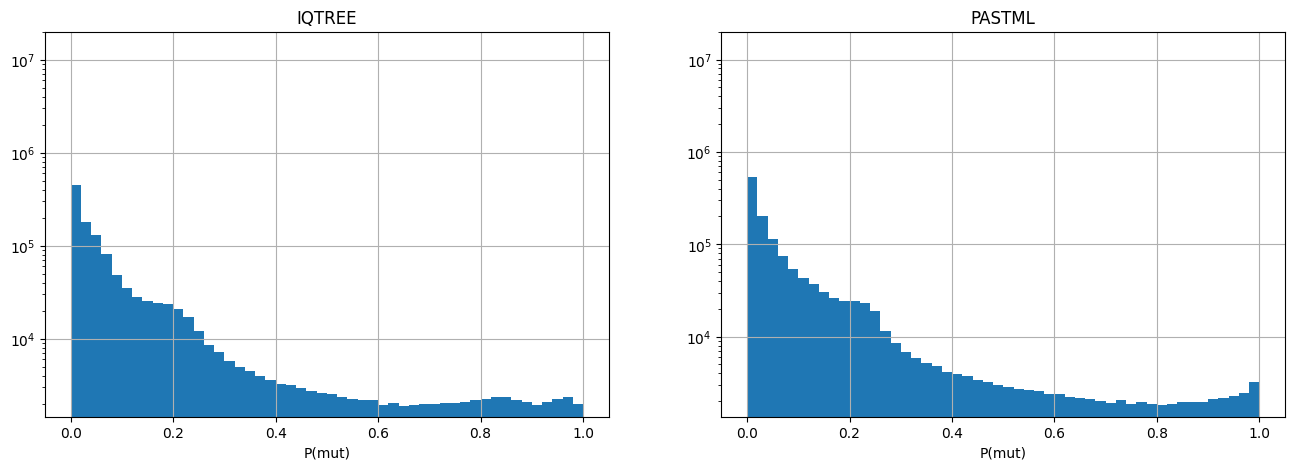

In [40]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
mut_iqtree.ProbaFull.hist(bins=50)
plt.yscale("log")
plt.title("IQTREE")
plt.xlabel("P(mut)")
plt.ylim(0, 2e7)

plt.subplot(1,2,2)
mut_pastml.ProbaFull.hist(bins=50)
plt.yscale("log")
plt.title("PASTML")
plt.xlabel("P(mut)")
plt.ylim(0, 2e7)
plt.show()

# НАЛОЖИТЬ В ОДИН

Сколько мутаций в каждом интервале вероятностей у обоих подходов

In [41]:
print("p1\tp2\t#iqtree\t#pastml")
for x1 in np.linspace(0, 1, 21)[:-1]:
    x2 = x1 + 0.05
    mut_exp_num_iqtree = mut_iqtree[(mut_iqtree.ProbaFull > x1) & (mut_iqtree.ProbaFull <= x2)].ProbaFull.sum()
    mut_exp_num_pastml = mut_pastml[(mut_pastml.ProbaFull > x1) & (mut_pastml.ProbaFull <= x2)].ProbaFull.sum()
    print(f"{x1:.2f}\t{x2:.2f}\t{mut_exp_num_iqtree:.1f}\t{mut_exp_num_pastml:.1f}")

p1	p2	#iqtree	#pastml
0.00	0.05	11787.4	12730.3
0.05	0.10	13418.1	12738.3
0.10	0.15	9300.3	11845.7
0.15	0.20	10529.5	11455.4
0.20	0.25	9875.8	13015.7
0.25	0.30	5822.3	7568.6
0.30	0.35	4253.2	4958.1
0.35	0.40	3631.6	4266.9
0.40	0.45	3396.4	3985.3
0.45	0.50	3197.8	3740.5
0.50	0.55	3159.1	3627.3
0.55	0.60	3154.0	3606.7
0.60	0.65	3089.5	3577.9
0.65	0.70	3283.7	3494.4
0.70	0.75	3645.3	3526.5
0.75	0.80	4135.9	3683.4
0.80	0.85	4781.2	3847.4
0.85	0.90	4718.7	4267.6
0.90	0.95	4758.4	4978.4
0.95	1.00	5332.8	6659.7


In [55]:
freqs_simple

,Node,Gene,Label,A>C,A>G,A>T,C>A,C>G,C>T,G>A,...,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T,Aproach
0,Node1242,1,all,328,328,328,278,278,278,113,...,3,15,4,1,3,12,15,4,8,simple
1,Node1242,1,syn,134,188,134,43,43,145,2,...,0,1,0,0,0,0,0,2,0,simple
2,Node1242,1,ff,134,134,134,43,43,43,0,...,0,1,0,0,0,0,0,2,0,simple
3,Node1243,1,all,321,321,321,287,287,287,113,...,6,13,5,1,3,13,15,4,8,simple
4,Node1243,1,syn,127,181,127,51,51,152,2,...,0,0,0,0,0,1,0,2,0,simple
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,Node886,1,syn,96,158,96,49,49,128,5,...,2,0,0,0,1,2,2,1,1,simple
3962,Node886,1,ff,96,96,96,49,49,49,4,...,2,0,0,0,1,2,2,1,1,simple
3963,Node887,1,all,301,301,301,269,269,269,110,...,22,9,4,2,3,30,25,4,18,simple
3964,Node887,1,syn,94,154,94,49,49,124,9,...,2,0,0,0,1,2,2,1,1,simple


In [25]:
mut_iqtree

,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,ProbaFull,RefNode,AltNode,Gene,Aproach
0,T[C>T]A,1,6,3,TTC,TTT,F,F,0.251434,0.170464,0.154744,Node1242,Node1243,1,iqtree
1,T[T>C]A,1,6,3,TTT,TTC,F,F,0.676315,0.173435,0.157441,Node1242,Node1243,1,iqtree
2,T[C>T]G,1,6,3,TTC,TTT,F,F,0.019502,0.000925,0.000839,Node1242,Node1243,1,iqtree
3,T[T>C]G,1,6,3,TTT,TTC,F,F,0.052458,0.000941,0.000854,Node1242,Node1243,1,iqtree
4,C[A>G]T,0,7,1,ATA,GTA,M,V,0.224317,0.003597,0.003265,Node1242,Node1243,1,iqtree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1186305,A[T>C]A,1,705,3,AAT,AAC,N,N,0.996700,0.996700,0.992737,Node886,RN_8,1,iqtree
1186306,A[T>C]A,1,750,3,TAT,TAC,Y,Y,0.233545,0.233545,0.232617,Node886,RN_8,1,iqtree
1186307,T[G>A]T,2,915,3,GTG,GTA,V,V,0.998520,0.998520,0.994549,Node886,RN_8,1,iqtree
1186308,T[G>A]C,2,921,3,CTG,CTA,L,L,0.037900,0.037900,0.037749,Node886,RN_8,1,iqtree


In [57]:
mut_iqtree[mut_iqtree.ProbaFull > 0.3].groupby(["RefNode", "AltNode", "Label", "Mut"]).ProbaFull.sum().unstack(level=-1)

Mut                    A[A>C]A  A[A>C]C  A[A>C]G  A[A>C]T   A[A>G]A   A[A>G]C  \
RefNode AltNode Label                                                           
Node1   RN_1089 0          NaN      NaN      NaN      NaN       NaN       NaN   
                1          NaN      NaN      NaN      NaN       NaN       NaN   
                2          NaN      NaN      NaN      NaN       NaN       NaN   
        RN_1093 0          NaN      NaN      NaN      NaN       NaN       NaN   
                1          NaN      NaN      NaN      NaN  0.833855  0.822437   
...                        ...      ...      ...      ...       ...       ...   
Node999 RN_1122 1          NaN      NaN      NaN      NaN       NaN       NaN   
                2          NaN      NaN      NaN      NaN       NaN       NaN   
        RN_1125 0          NaN      NaN      NaN      NaN       NaN       NaN   
                1          NaN      NaN      NaN      NaN       NaN       NaN   
                2          NaN      NaN      NaN      NaN       NaN       NaN   

Mut                     A[A>G]G   A[A>G]T  A[A>T]A  A[A>T]C  ...  T[T>A]G  \
RefNode AltNode Label                                        ...            
Node1   RN_1089 0           NaN       NaN      NaN      NaN  ...      NaN   
                1      0.854588       NaN      NaN      NaN  ...      NaN   
                2           NaN       NaN      NaN      NaN  ...      NaN   
        RN_1093 0           NaN       NaN      NaN      NaN  ...      NaN   
                1           NaN  0.818447      NaN      NaN  ...      NaN   
...                         ...       ...      ...      ...  ...      ...   
Node999 RN_1122 1           NaN       NaN      NaN      NaN  ...      NaN   
                2           NaN       NaN      NaN      NaN  ...      NaN   
        RN_1125 0           NaN       NaN      NaN      NaN  ...      NaN   
                1           NaN  0.977269      NaN      NaN  ...      NaN   
                2           NaN       NaN      NaN      NaN  ...      NaN   

Mut                    T[T>A]T   T[T>C]A   T[T>C]C   T[T>C]G   T[T>C]T  \
RefNode AltNode Label                                                    
Node1   RN_1089 0          NaN       NaN       NaN       NaN       NaN   
                1          NaN  2.841232  1.239394  0.440117       NaN   
                2          NaN       NaN  0.351027       NaN  0.388655   
        RN_1093 0          NaN       NaN       NaN       NaN       NaN   
                1          NaN  1.804376  0.450829  0.908646  0.403436   
...                        ...       ...       ...       ...       ...   
Node999 RN_1122 1          NaN       NaN       NaN       NaN       NaN   
                2          NaN       NaN       NaN       NaN       NaN   
        RN_1125 0          NaN       NaN       NaN       NaN       NaN   
                1          NaN       NaN       NaN       NaN       NaN   
                2          NaN       NaN       NaN       NaN       NaN   

Mut                    T[T>G]A  T[T>G]C  T[T>G]G  T[T>G]T  
RefNode AltNode Label                                      
Node1   RN_1089 0          NaN      NaN      NaN      NaN  
                1          NaN      NaN      NaN      NaN  
                2          NaN      NaN      NaN      NaN  
        RN_1093 0          NaN      NaN      NaN      NaN  
                1          NaN      NaN      NaN      NaN  
...                        ...      ...      ...      ...  
Node999 RN_1122 1          NaN      NaN      NaN      NaN  
                2          NaN      NaN      NaN      NaN  
        RN_1125 0          NaN      NaN      NaN      NaN  
                1          NaN      NaN      NaN      NaN  
                2          NaN      NaN      NaN      NaN  

[6737 rows x 190 columns]

In [7]:
def calc_tree_mutspec(mut, freqs, lbl="syn", pmin=0.0, pmax=1.0, collapse=False):
    """
    calculate tree mutspec from history files
    
    return mutspec of each edge in one table
    """
    # sample mutations
    mut = mut[mut.ProbaFull.between(pmin, pmax)]
    
    mutspec = []
    for (ref_node, alt_node), cur_mut in mut.groupby(["RefNode", "AltNode"]):
        # sample freqs
        _cur_freq_df = freqs[(freqs.Node == ref_node) & (freqs.Label == lbl)]
        cur_freq = _cur_freq_df[possible_sbs192].sum(axis=0).to_dict()

        # calculate mutspec
        ms192 = calculate_mutspec(cur_mut[cur_mut.Label >= lbl2lbl_id(lbl)], cur_freq, use_context=True, use_proba=True)  # !!!!!!! FUCK
        ms192["RefNode"] = ref_node
        ms192["AltNode"] = alt_node
        ms192["Label"] = lbl
        mutspec.append(ms192)
    mutspec_df = pd.concat(mutspec)
    if collapse:
        mutspec_df = mutspec_df.groupby(["RefNode", "AltNode", "Label"]).apply(collapse_mutspec).reset_index()
    mutspec_df["MutBase"] = mutspec_df.Mut.str.slice(2, 5)
    mutspec_df["Context"] = mutspec_df.Mut.str.get(0) + mutspec_df.Mut.str.get(2) + mutspec_df.Mut.str.get(-1)
    return mutspec_df

In [8]:
space = [0.00, 0.05, 0.30, .50, 0.80, 1.00]

In [10]:
for p1, p2 in zip(space[:-1], space[1:]):
    mut_exp_num_iqtree = mut_iqtree[(mut_iqtree.ProbaFull > p1) & (mut_iqtree.ProbaFull <= p2)].ProbaFull.sum()
    mut_exp_num_pastml = mut_pastml[(mut_pastml.ProbaFull > p1) & (mut_pastml.ProbaFull <= p2)].ProbaFull.sum()
    print(f"{p1:.2f}\t{p2:.2f}\t{mut_exp_num_iqtree:.1f}\t{mut_exp_num_pastml:.1f}")

0.00	0.05	11787.4	12730.3
0.05	0.30	48946.0	56623.7
0.30	0.50	14478.9	16950.8
0.50	0.80	20467.6	21516.2
0.80	1.00	19591.1	19753.2


In [11]:
ms_cat_iqtree = []
for p1, p2 in zip(space[:-1], space[1:]):
    ms = calc_tree_mutspec(mut_iqtree, freqs_iqtree, "syn", p1, p2)
    ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
    ms_cat_iqtree.append(ms)

ms_cat_iqtree_df = pd.concat(ms_cat_iqtree)

In [12]:
ms_cat_pastml = []
for p1, p2 in zip(space[:-1], space[1:]):
    ms = calc_tree_mutspec(mut_pastml, freqs_pastml, "syn", p1, p2)
    ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
    ms_cat_pastml.append(ms)

ms_cat_pastml_df = pd.concat(ms_cat_pastml)

### Categorized mutspec 

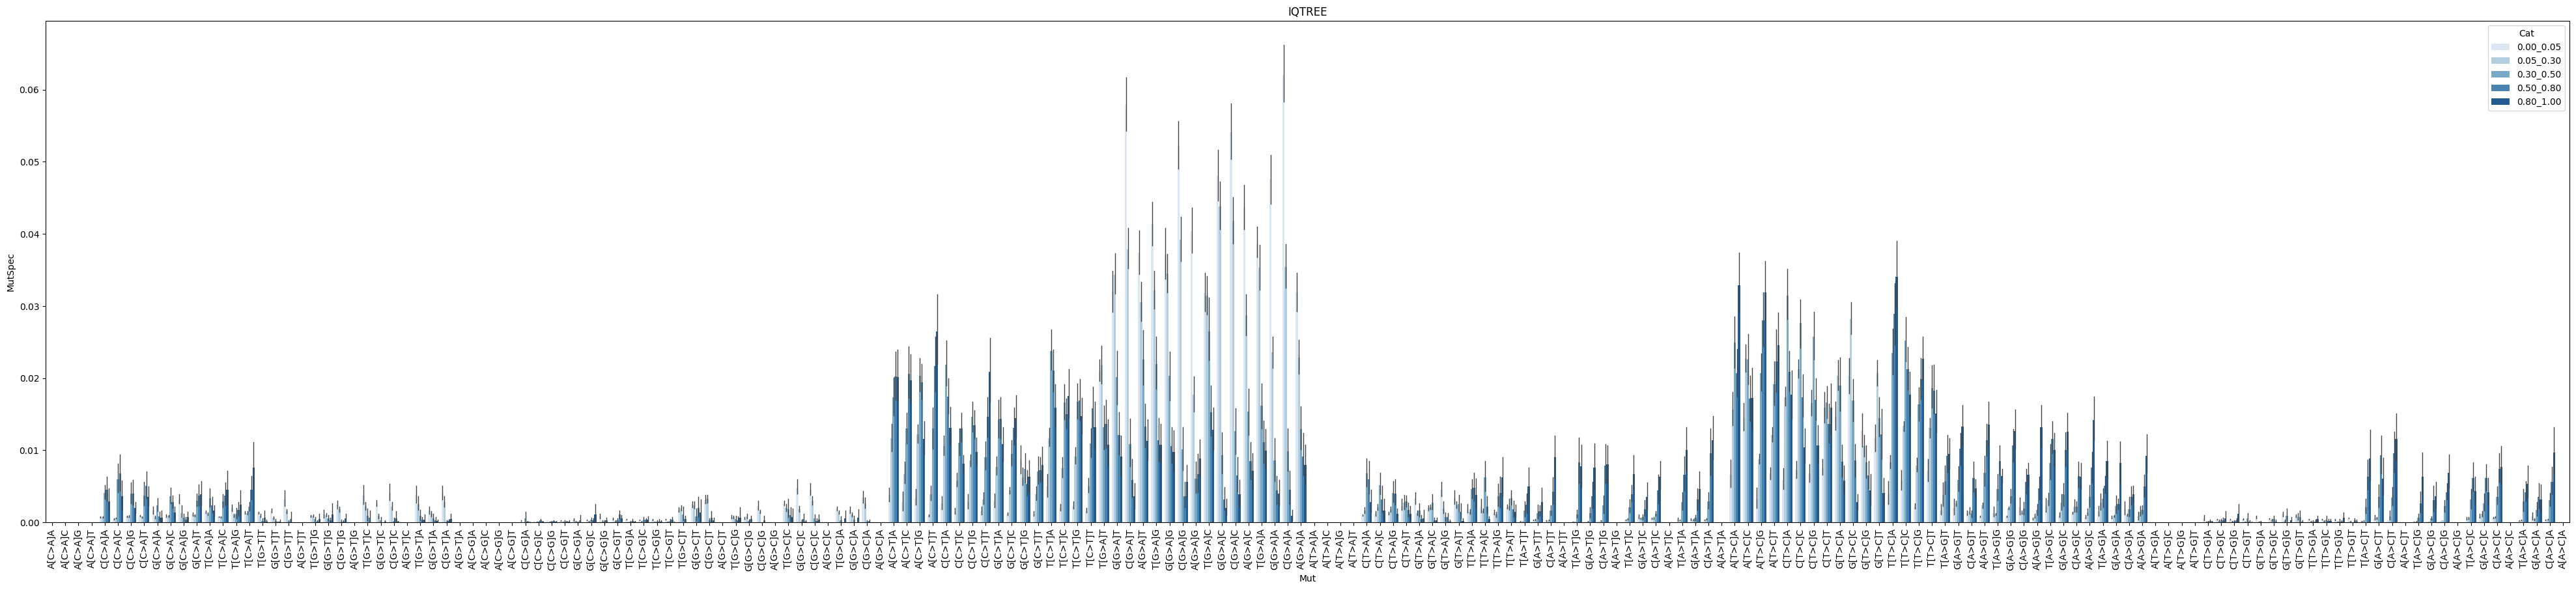

In [17]:
plt.figure(figsize=(50, 10))
sns.barplot(
    x="Mut", y="MutSpec", hue="Cat", data=ms_cat_iqtree_df, errwidth=1, order=ordered_sbs192_kp, palette="Blues",
)
plt.title("IQTREE")
plt.xticks(rotation=90);
plt.savefig("../figures/mammals_nd1_iqtree_mut_proba_cats.svg", bbox_inches="tight")
plt.show()

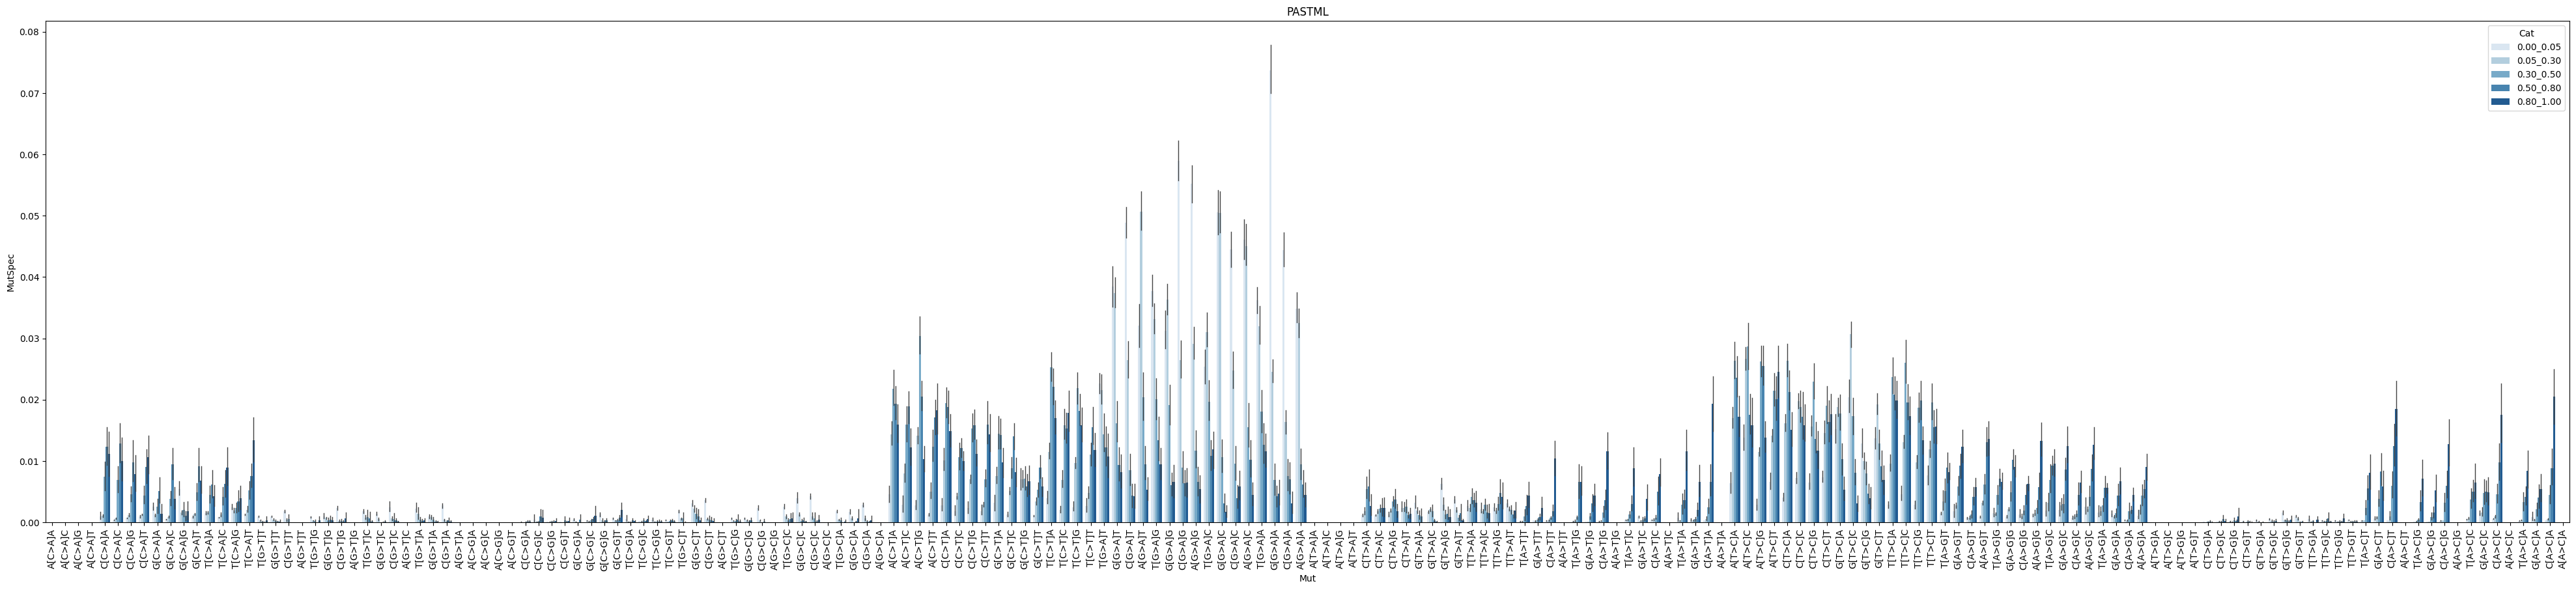

In [18]:
plt.figure(figsize=(50, 10))
sns.barplot(
    x="Mut", y="MutSpec", hue="Cat", data=ms_cat_pastml_df, errwidth=1, order=ordered_sbs192_kp, palette="Blues",
)
plt.title("PASTML")
plt.xticks(rotation=90)
plt.savefig("../figures/mammals_nd1_pastml_mut_proba_cats.svg", bbox_inches="tight")
plt.show()

Разглядывать сложно. Но виден сильный дисбаланс.Как по низковероятным мутациям, так и по высоковероятным

### Compare cossim of mutspecs on mutations samples

In [28]:
def plot_compared(p1, p2, lbl="syn", constant_pastml=False):
    ms_simple = mutspec_simple192[(mutspec_simple192.Label == lbl)]
    ms_iqtree = calc_tree_mutspec(mut_iqtree, freqs_iqtree, lbl, p1, p2)
    if constant_pastml:
        ms_pastml = calc_tree_mutspec(mut_pastml, freqs_pastml, lbl, 0, 1)
    else:
        ms_pastml = calc_tree_mutspec(mut_pastml, freqs_pastml, lbl, p1, p2)
    sims_data = []
    for anode in set(mutspec_simple192.AltNode):
        df1 = ms_simple[(ms_simple.AltNode == anode)].set_index("Mut").sort_index()
        df2 = ms_iqtree[(ms_iqtree.AltNode == anode)].set_index("Mut").sort_index()
        df3 = ms_pastml[(ms_pastml.AltNode == anode)].set_index("Mut").sort_index()
        if not df1.shape or not df2.shape or not df3.shape:
            continue

        sim12 = 1 - spatial.distance.cosine(df1["MutSpec"], df2["MutSpec"])
        sim13 = 1 - spatial.distance.cosine(df1["MutSpec"], df3["MutSpec"])
        sim23 = 1 - spatial.distance.cosine(df2["MutSpec"], df3["MutSpec"])
        
        sims_data.append({"AltNode": anode, "Pair": "simple & iqtree", "Cossim": sim12})
        sims_data.append({"AltNode": anode, "Pair": "iqtree & pastml", "Cossim": sim23})
        sims_data.append({"AltNode": anode, "Pair": "simple & pastml", "Cossim": sim13})

    sims_df = pd.DataFrame(sims_data)
    
    # https://python.plainenglish.io/ridge-plots-with-pythons-seaborn-4de5725881af
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
    palette = sns.color_palette("Set2", 12)
    g = sns.FacetGrid(sims_df, palette=palette, row="Pair", hue="Pair", aspect=4, height=2.0)
    g.map_dataframe(sns.kdeplot, x="Cossim", fill=True, alpha=1)
    g.map_dataframe(sns.kdeplot, x="Cossim", color='black')

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, color='black', fontsize=13,
                ha="left", va="center", transform=ax.transAxes)
        
    g.map(label, "Pair")
    g.fig.subplots_adjust(hspace=-.5)
    g.set_titles("")
    g.set(yticks=[], xlabel="cossim", ylabel="")
    g.despine(left=True)
    title = f"Proba: ({p1}, {p2}]"
    if constant_pastml:
        title = f"Proba: iqtree: ({p1}, {p2}]; pastml: (0, 1]"
    plt.suptitle(title, y=0.98)
    plt.xlim(0, 1.01)
    plt.xticks(np.linspace(-0.1, 1.1, 13))
    plt.show()

Ниже графики, в которых мутспек считается по подвыборке мутаций с указанной вероятностью. 

Сначала идут графики, где мутации фильтровались как для iqtree, так и для pastml. Далее идут графики, где мутации фильтруются только у iqtree

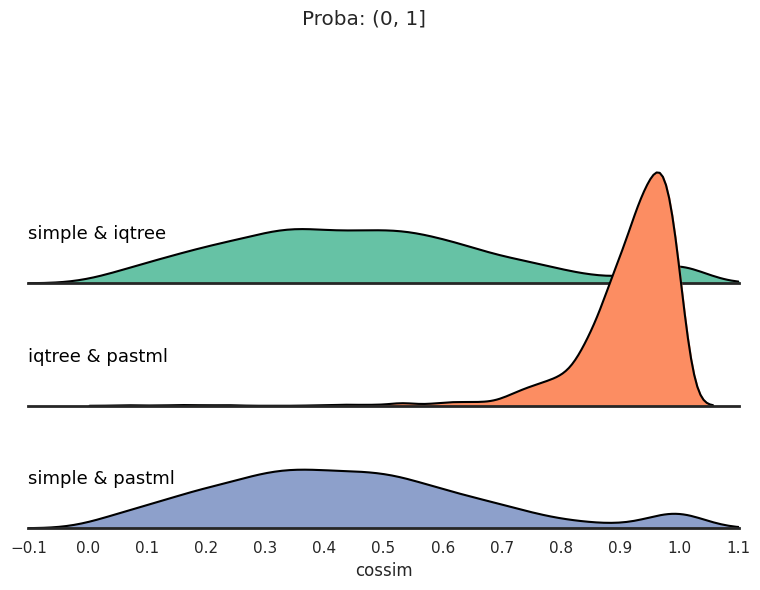

In [19]:
plot_compared(0, 1)

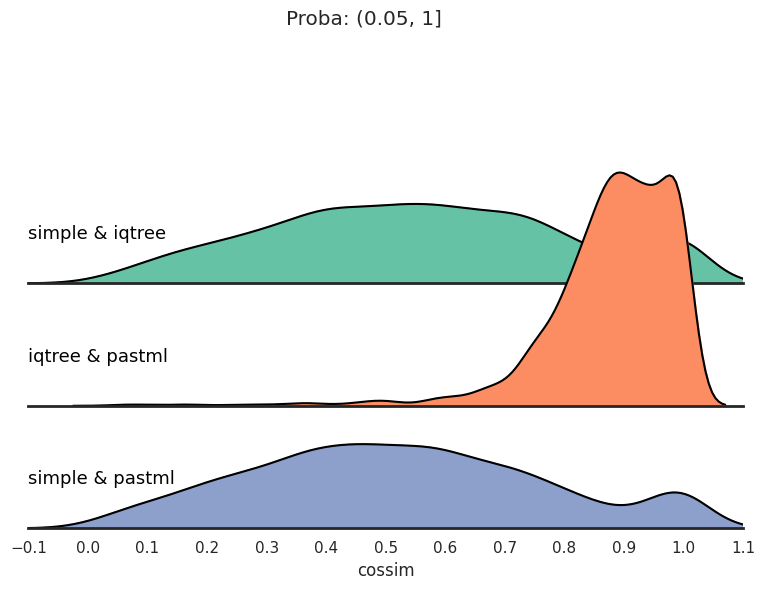

In [20]:
plot_compared(0.05, 1)

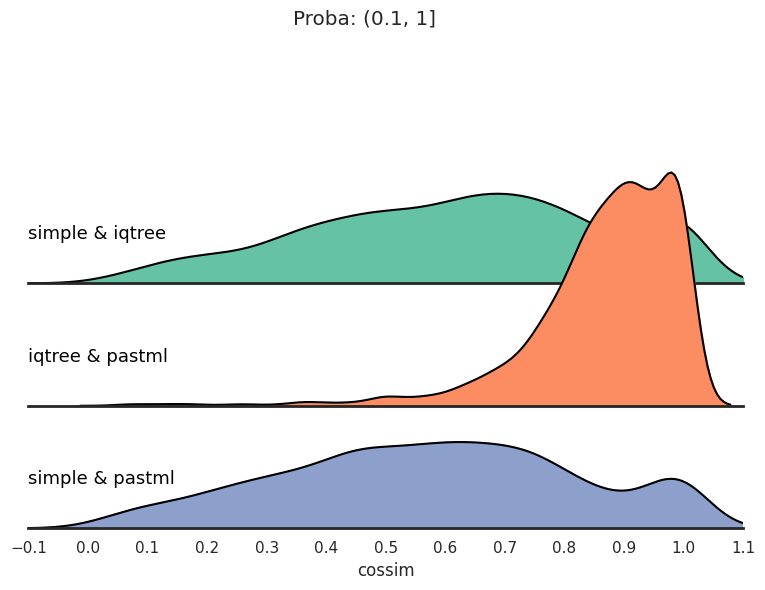

In [21]:
plot_compared(0.1, 1)

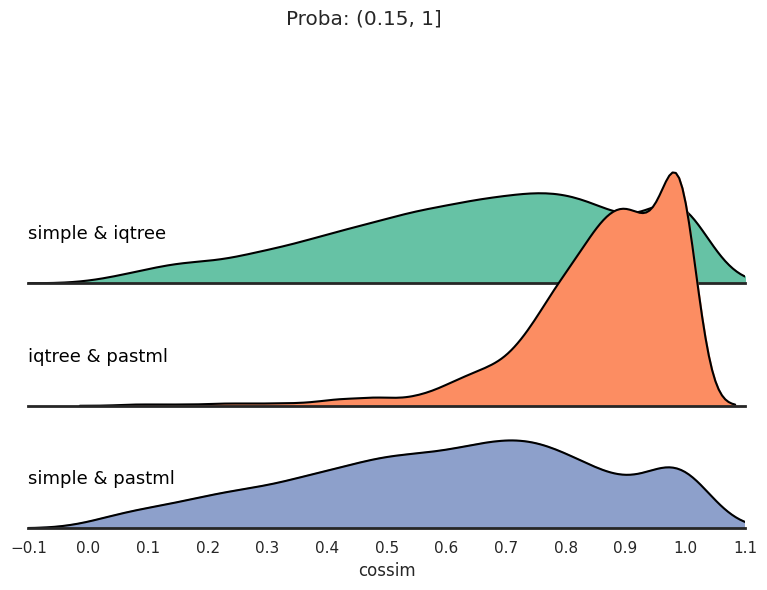

In [22]:
plot_compared(0.15, 1)

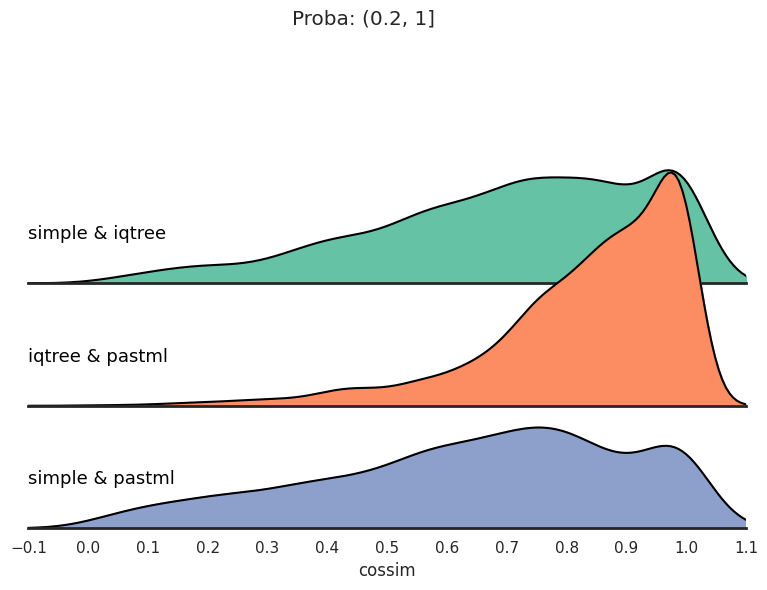

In [23]:
plot_compared(0.20, 1)

In [29]:
plot_compared(0.40, 1)

ValueError: operands could not be broadcast together with shapes (192,) (0,) 

Далее полная выборка мутаций из pastml сравнивается с разными выборками из iqtree

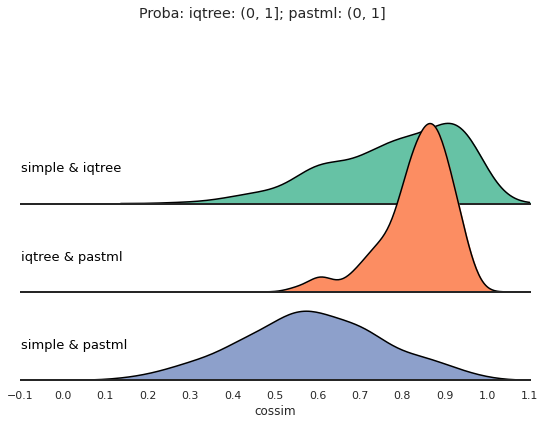

In [ ]:
plot_compared(0, 1, constant_pastml=True)

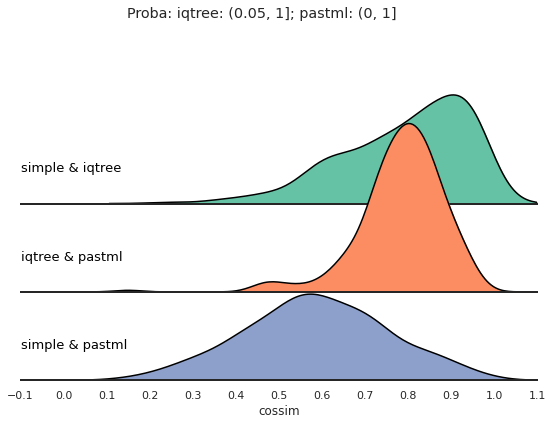

In [ ]:
plot_compared(0.05, 1, constant_pastml=True)

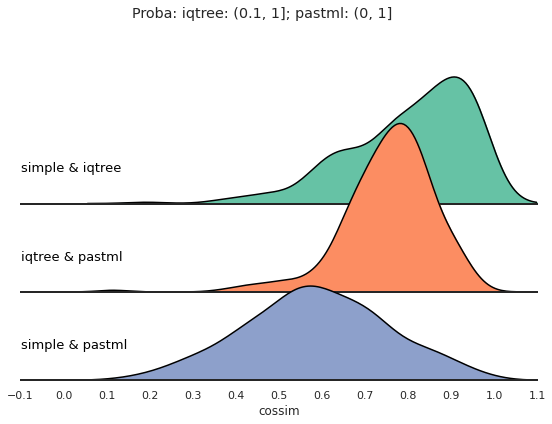

In [ ]:
plot_compared(0.1, 1, constant_pastml=True)

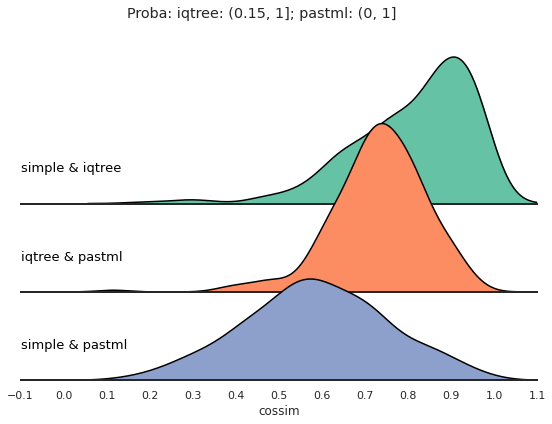

In [ ]:
plot_compared(0.15, 1, constant_pastml=True)